In [66]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torchvision.transforms as T

from dataset import ChexpertSmall

import matplotlib.pyplot as plt
%matplotlib inline

#### Test Dataset class

In [2]:
ds = ChexpertSmall('', mode='valid')
print('length: ', len(ds))
print('attributes: ', ds.attr_names)

length:  234
attributes:  ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']


#### Preview an image

tensor([0., 1., 0., 0., 0.])
CheXpert-v1.0-small/valid/patient64541/study1
<PIL.JpegImagePlugin.JpegImageFile image mode=L size=390x320 at 0x12A993048>


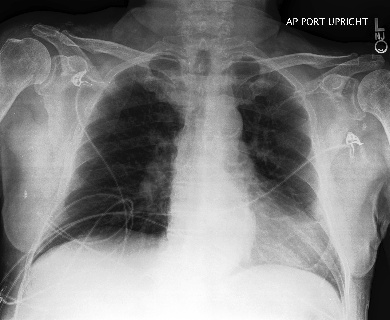

In [3]:
img, attr, patient_id = ds[0]
print(attr)
print(patient_id)
print(img)
img

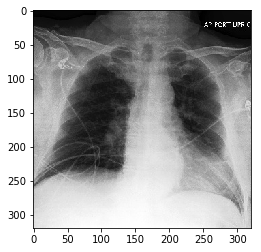

In [4]:
transforms = T.Compose([
    T.CenterCrop(320),
    T.ToTensor(),
    T.Lambda(lambda x: x.expand(3,-1,-1))])
plt.imshow(transforms(img).permute(1,2,0))

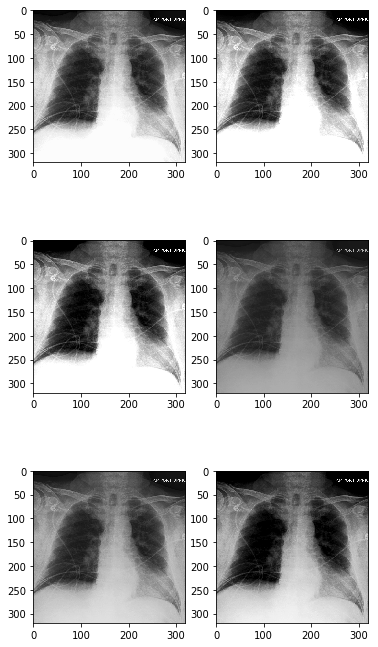

In [12]:
transforms = T.Compose([
    T.CenterCrop(320),
    T.ColorJitter(brightness=0.25, contrast=0.25),
    T.ToTensor(),
    T.Lambda(lambda x: x.expand(3,-1,-1))])
_, axs = plt.subplots(3,2, figsize=(6,12))
for ax in axs.flatten():
    ax.imshow(transforms(img).permute(1,2,0))

# Explore data

## Training data

####  Labels

Per https://stanfordmlgroup.github.io/competitions/chexpert/ :

Our labeler is set up in three distinct stages: mention extraction, mention classification, and mention aggregation. In the mention extraction stage, the labeler extracts mentions from a list of observations from the Impression section of radiology reports, which summarizes the key findings in the radiographic study. In the mention classification stage, mentions of observations are classified as negative, uncertain, or positive. In the mention aggregation stage, we use the classification for each mention of observations to arrive at a final label for the 14 observations: 

**blank for unmentioned, 0 for negative, -1 for uncertain, and 1 for positive**.

In [143]:
data_path = '/Users/Kamen/Data/'
dir_name = 'CheXpert-v1.0-small/'
train_file = 'train.csv'
valid_file = 'valid.csv'
attr_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

train_data = pd.read_csv(os.path.join(data_path, dir_name, train_file), keep_default_na=True)

# feature columns ['No Finding', ..., 'Support Devices']
feature_cols = train_data.columns[5:]

# replace uncertain labels -1 with method in paper; e.g. U-Ones
# train_data[feature_cols] = train_data[feature_cols].replace(-1,1)

train_data.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


#### NA values

In [144]:
train_data.isna().sum()

Path                               0
Sex                                0
Age                                0
Frontal/Lateral                    0
AP/PA                          32387
No Finding                    201033
Enlarged Cardiomediastinum    178575
Cardiomegaly                  177211
Lung Opacity                  105636
Lung Lesion                   211470
Edema                         137458
Consolidation                 152792
Pneumonia                     195806
Atelectasis                   154971
Pneumothorax                  144480
Pleural Effusion               90203
Pleural Other                 216922
Fracture                      211220
Support Devices               100197
dtype: int64

In [145]:
# replace blanks (unmentioned) with 0s (negative); note AP/PA remains with NAs for Lateral pictures
train_data[feature_cols] = train_data[feature_cols].fillna(0)
train_data.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Summary stats

In [146]:
train_data['Sex'].value_counts()

Male       132636
Female      90777
Unknown         1
Name: Sex, dtype: int64

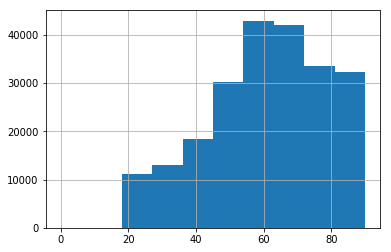

In [147]:
train_data['Age'].hist()

In [148]:
train_data['Frontal/Lateral'].value_counts()

Frontal    191027
Lateral     32387
Name: Frontal/Lateral, dtype: int64

In [149]:
train_data['AP/PA'].value_counts()

AP    161590
PA     29420
LL        16
RL         1
Name: AP/PA, dtype: int64

#### Labels distribution for each condition:

-1 = uncertain   <br>
0 = negative    <br>
1 = positive    <br>
blank = unmentioned <br>

In [150]:
prevalence = train_data[train_data.columns[5:]].apply(pd.Series.value_counts, dropna=False).T
prevalence['prevalence (-1 & 1)'] = (prevalence[[-1.0, 1.0]].sum(1) / prevalence.sum(1)).round(3) * 100
prevalence

,-1.0,0.0,1.0,prevalence (-1 & 1)
No Finding,NaN,201033.0,22381.0,10.0
Enlarged Cardiomediastinum,12403.0,200213.0,10798.0,10.4
Cardiomegaly,8087.0,188327.0,27000.0,15.7
Lung Opacity,5598.0,112235.0,105581.0,49.8
Lung Lesion,1488.0,212740.0,9186.0,4.8
Edema,12984.0,158184.0,52246.0,29.2
Consolidation,27742.0,180889.0,14783.0,19.0
Pneumonia,18770.0,198605.0,6039.0,11.1
Atelectasis,33739.0,156299.0,33376.0,30.0
Pneumothorax,3145.0,200821.0,19448.0,10.1


In [151]:
# replace uncertain labels -1 with method in paper; e.g. U-Ones
train_data[feature_cols] = train_data[feature_cols].replace(-1,1)

#### Picture type for each condition

In [152]:
train_data.groupby('Frontal/Lateral').sum().T

Frontal/Lateral,Frontal,Lateral
Age,11590175.0,1910879.0
No Finding,16974.0,5407.0
Enlarged Cardiomediastinum,19473.0,3728.0
Cardiomegaly,30092.0,4995.0
Lung Opacity,98642.0,12537.0
Lung Lesion,8148.0,2526.0
Edema,61493.0,3737.0
Consolidation,37364.0,5161.0
Pneumonia,20656.0,4153.0
Atelectasis,59583.0,7532.0


In [153]:
train_data.groupby('Path')[train_data.columns[5:]].max()[:2].values

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]])

In [154]:
train_data.groupby('AP/PA').sum().T

AP/PA,AP,LL,PA,RL
Age,9911271.0,938.0,1677922.0,44.0
No Finding,11471.0,4.0,5499.0,0.0
Enlarged Cardiomediastinum,16177.0,1.0,3295.0,0.0
Cardiomegaly,26040.0,4.0,4048.0,0.0
Lung Opacity,87845.0,4.0,10793.0,0.0
Lung Lesion,5666.0,0.0,2482.0,0.0
Edema,58944.0,1.0,2548.0,0.0
Consolidation,33046.0,2.0,4316.0,0.0
Pneumonia,17184.0,2.0,3470.0,0.0
Atelectasis,53140.0,4.0,6439.0,0.0


### Co-occurence

In [160]:
train_data[attr_names].T.dot(train_data[attr_names]).astype(int)

,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural Effusion
Atelectasis,67115,10557,27426,19740,35977
Cardiomegaly,10557,35087,6480,17067,16770
Consolidation,27426,6480,42525,10949,22934
Edema,19740,17067,10949,65230,33088
Pleural Effusion,35977,16770,22934,33088,97815


#### Singlular conditions

In [165]:
train_data.loc[train_data[attr_names].sum(1)==1, attr_names].sum(0)

Atelectasis         12044.0
Cardiomegaly         6862.0
Consolidation        5666.0
Edema               16563.0
Pleural Effusion    30435.0
dtype: float64

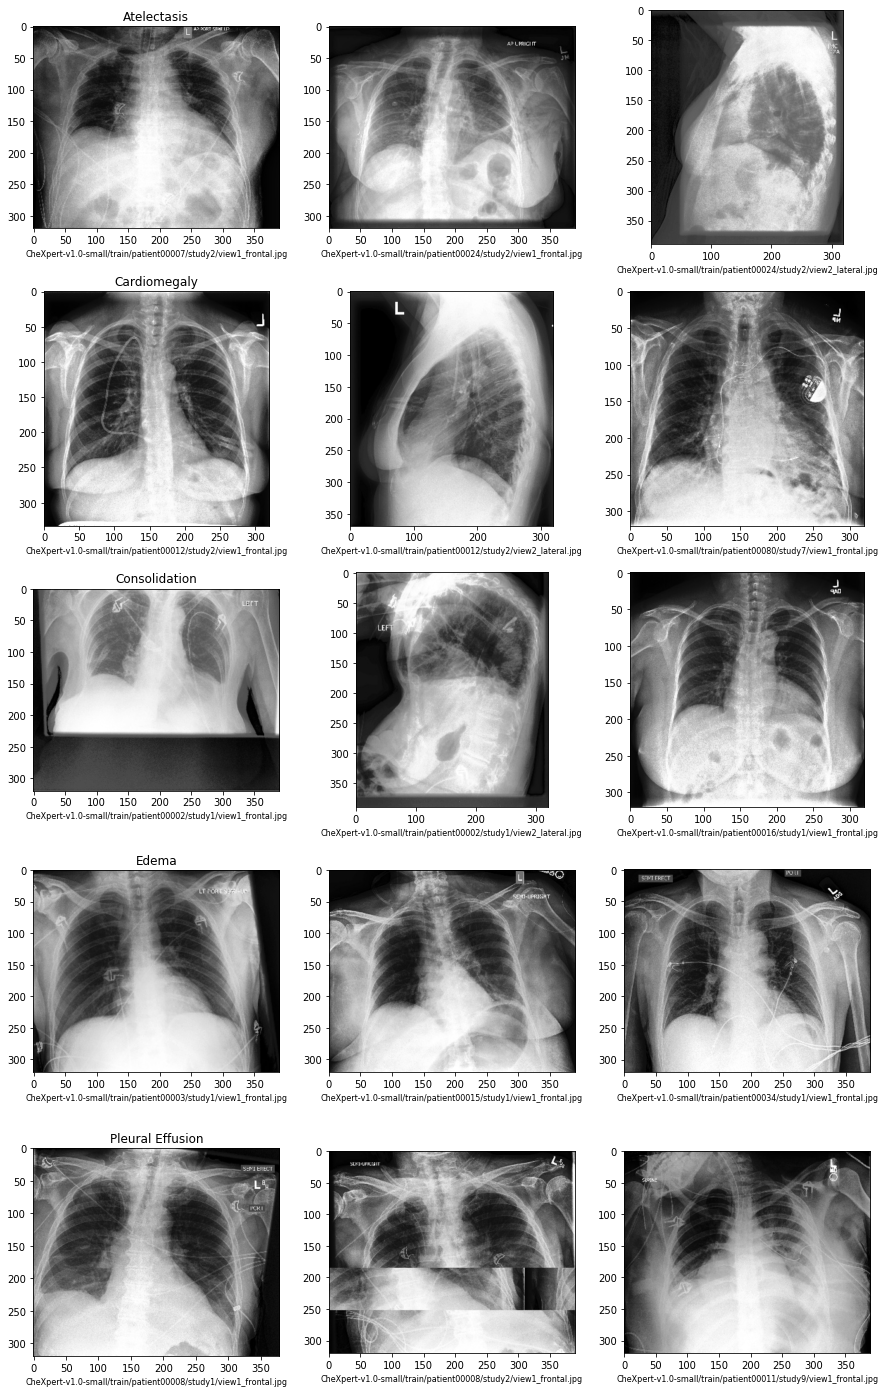

In [219]:
fig, axs = plt.subplots(len(attr_names), 3, figsize=(3*5, 5*5))

for i, a in enumerate(attr_names):
    filenames = train_data.loc[(train_data[a]==1) & (train_data[attr_names].sum(1)==1), 'Path'].head(3).values
    axs[i,0].set_title(a)
    for j, f in enumerate(filenames):
        img = Image.open(filenames[j])
        axs[i,j].imshow(img, cmap='gray', interpolation='bilinear')
        axs[i,j].set_xlabel(filenames[j], fontsize=8)

#### Multiple conditions

In [168]:
train_data.loc[train_data[attr_names].sum(1)>1, attr_names].sum(0)

Atelectasis         55071.0
Cardiomegaly        28225.0
Consolidation       36859.0
Edema               48667.0
Pleural Effusion    67380.0
dtype: float64

## Validation data

In [220]:
valid_data = pd.read_csv(os.path.join(data_path, dir_name, valid_file), keep_default_na=True)
# replace blanks (unmentioned) with 0s (negative); note AP/PA remains with NAs for Lateral pictures
valid_data[feature_cols] = valid_data[feature_cols].fillna(0)
valid_data[['Path'] + attr_names].head()

,Path,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural Effusion
0,CheXpert-v1.0-small/valid/patient64541/study1/...,0.0,1.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0,0.0,0.0,0.0,0.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0,0.0,0.0,0.0,0.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,0.0,0.0,0.0,1.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,0.0,0.0,0.0,0.0,0.0


### View single conditions only 

In [232]:
for a in attr_names:
    print(a)
    print(valid_data.loc[(valid_data[a]==1) & (valid_data[attr_names].sum(1)==1), attr_names].head())
    print()
print('No finding')
print(valid_data.loc[valid_data[attr_names].sum(1)==0, attr_names].head())

Atelectasis
    Atelectasis  Cardiomegaly  Consolidation  Edema  Pleural Effusion
26          1.0           0.0            0.0    0.0               0.0
27          1.0           0.0            0.0    0.0               0.0
28          1.0           0.0            0.0    0.0               0.0
33          1.0           0.0            0.0    0.0               0.0
34          1.0           0.0            0.0    0.0               0.0

Cardiomegaly
    Atelectasis  Cardiomegaly  Consolidation  Edema  Pleural Effusion
0           0.0           1.0            0.0    0.0               0.0
11          0.0           1.0            0.0    0.0               0.0
16          0.0           1.0            0.0    0.0               0.0
32          0.0           1.0            0.0    0.0               0.0
42          0.0           1.0            0.0    0.0               0.0

Consolidation
    Atelectasis  Cardiomegaly  Consolidation  Edema  Pleural Effusion
50          0.0           0.0            1.0    0

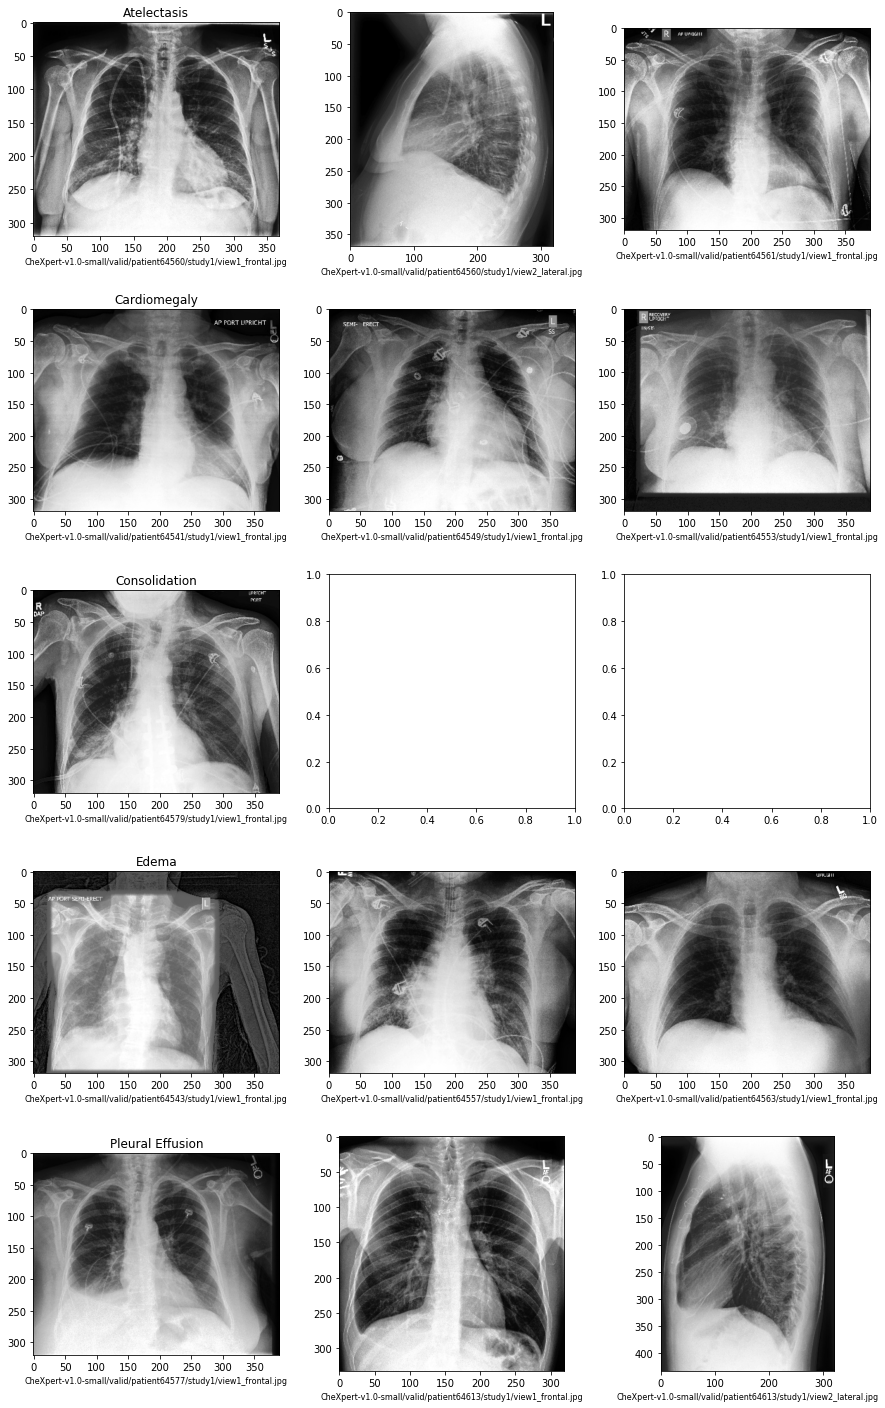

In [227]:
fig, axs = plt.subplots(len(attr_names), 3, figsize=(3*5, 6*5))

for i, a in enumerate(attr_names):
    filenames = valid_data.loc[(valid_data[a]==1) & (valid_data[attr_names].sum(1)==1), 'Path'].head(3).values
    axs[i,0].set_title(a)
    for j, f in enumerate(filenames):
        img = Image.open(filenames[j])
        axs[i, j].imshow(img, cmap='gray', interpolation='bilinear')
        axs[i,j].set_xlabel(filenames[j], fontsize=8)

### Visualize 2 conditions

In [128]:
for i, a in enumerate(attr_names):
    print(a)
    one_hot = np.zeros((len(attr_names)))
    one_hot[i]=1
    print(valid_data.loc[(valid_data[a]==1) & (valid_data[attr_names].sum(1)==2), attr_names].head())
    print()

Atelectasis
    Atelectasis  Cardiomegaly  Consolidation  Edema  Pleural Effusion
5           1.0           0.0            0.0    0.0               1.0
6           1.0           1.0            0.0    0.0               0.0
31          1.0           1.0            0.0    0.0               0.0
38          1.0           1.0            0.0    0.0               0.0
41          1.0           0.0            0.0    0.0               1.0

Cardiomegaly
    Atelectasis  Cardiomegaly  Consolidation  Edema  Pleural Effusion
6           1.0           1.0            0.0    0.0               0.0
31          1.0           1.0            0.0    0.0               0.0
38          1.0           1.0            0.0    0.0               0.0
69          1.0           1.0            0.0    0.0               0.0
94          0.0           1.0            0.0    1.0               0.0

Consolidation
     Atelectasis  Cardiomegaly  Consolidation  Edema  Pleural Effusion
144          0.0           0.0            1.0   